## Import libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns

## Loading image

In [43]:
main_img = cv.imread('park.jpg')

In [44]:
main_img.shape

(3312, 4416, 3)

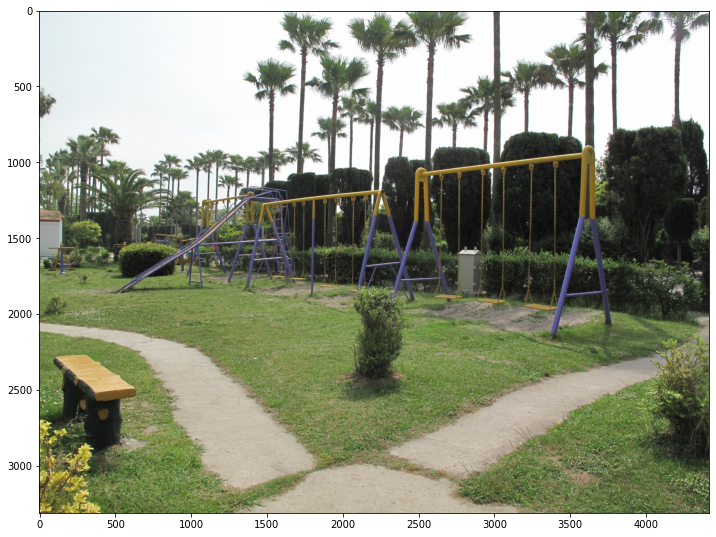

In [45]:
plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(main_img, cv.COLOR_BGR2RGB));

## Mean Shift

First I implemented the exact algorithm. But, it was too slow for segmenting this image.

Below is it's implementation. basicly, for each point, it moves along the path to it's corresponding center.

In [46]:
class MeanShift:
    def __init__(self, radius):
        self.radius = radius
    
    def fit(self, X):
        centroids = X.copy()

        while True:
            new_centroids = np.zeros_like(centroids, dtype=np.float32)
            
            labels_centroids, mask_labels = np.unique(centroids, axis=0, return_inverse=True)
            for label_idx in range(mask_labels.max()+1):
                neighbors = X[np.linalg.norm(X-labels_centroids[label_idx], axis=1) <= self.radius]
                new_centroids[mask_labels == label_idx] = np.average(neighbors, axis=0)

            if np.all(new_centroids == centroids):
                break   

            centroids = new_centroids
        
        return np.unique(centroids, axis=0, return_inverse=True)

In order to enhance the speed of the above implementation, I changed it a bit. What I did is describe as the following steps:
- While we have a point that isn't visited:
    - Move it to it's center (each step average it's neighbors)
    - During it's way, also label it's neighbors with the same label of this point
    - During it's way, if 70% of it's neighbors were labeled before, stop going furthur. Instead use their label to label this point (and the visited ones in the path)

In [98]:
class EnhancedMeanShift:
    def __init__(self, radius, continue_with_neighbors_th=0.3, stop_th=1e-4):
        self.radius = radius
        self.continue_with_neighbors_th = continue_with_neighbors_th
        self.stop_th = stop_th
    
    def fit(self, X):
        centroids = np.zeros_like(X, dtype=np.float32)
        visit = np.zeros(X.shape[0], dtype=bool)

        for x_idx in np.random.permutation(X.shape[0]):
            x = X[x_idx]
            if visit[x_idx]:
                continue

            update_mask = np.zeros_like(visit)
            update_mask[x_idx] = True
            center = x
            while True:
                mask = np.linalg.norm(X - center, axis=1) < self.radius
                update_mask[mask & ~visit] = True

                if np.sum(visit[mask])/np.sum(mask) >= self.continue_with_neighbors_th:
                    visit[update_mask] = True
                    neighbors_centroids, cnt = np.unique(centroids[visit & mask], axis=0, return_counts=True)
                    centroids[update_mask] = neighbors_centroids[cnt.argmax()]
                    break

                new_center = np.average(X[mask], axis=0)
                
                if np.all(np.linalg.norm(new_center - center) < self.stop_th):
                    centroids[update_mask] = new_center
                    visit[update_mask] = True
                    break
                
                center = new_center
        
        return np.unique(centroids, axis=0, return_inverse=True)
        

#### Testing on sample data

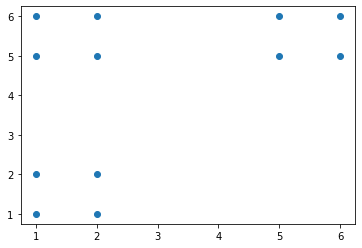

In [125]:
X = np.array([
    [1, 1],
    [2, 2],
    [1, 2],
    [2, 1],
    [5, 5],
    [5, 6],
    [6, 5],
    [6, 6],
    [1, 5],
    [2, 5],
    [1, 6],
    [2, 6]
])
plt.scatter(X[:, 0], X[:, 1]);

In [126]:
centroids, labels = EnhancedMeanShift(2).fit(X)

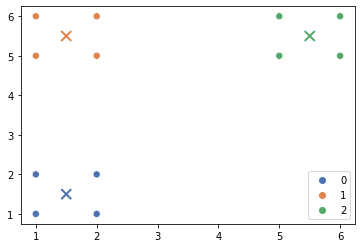

In [127]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='deep', s=50)
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], marker='x', color='black', s=100, hue=np.unique(labels), palette='deep', linewidth=2, legend=False);

Perfect!

## Result

It's better to incorporate $(X, Y)$ along side $(L, U, V)$ feature space. It's feasible for scaled down version of the image. But, in the full resolution image, it will take a long time to finish.

#### Down scaled image

In [128]:
scaled_img = main_img[::10, ::10]

alpha = 0.3
features = np.dstack((
    cv.cvtColor(scaled_img, cv.COLOR_BGR2LUV),
    np.transpose(np.indices(scaled_img.shape[:2]), (1, 2, 0)) * alpha
))

_, labels = EnhancedMeanShift(radius=8, continue_with_neighbors_th=0.7).fit(
    features.reshape(-1, 5)
)

I used median blur in order to smoothen the image (prettier result!)

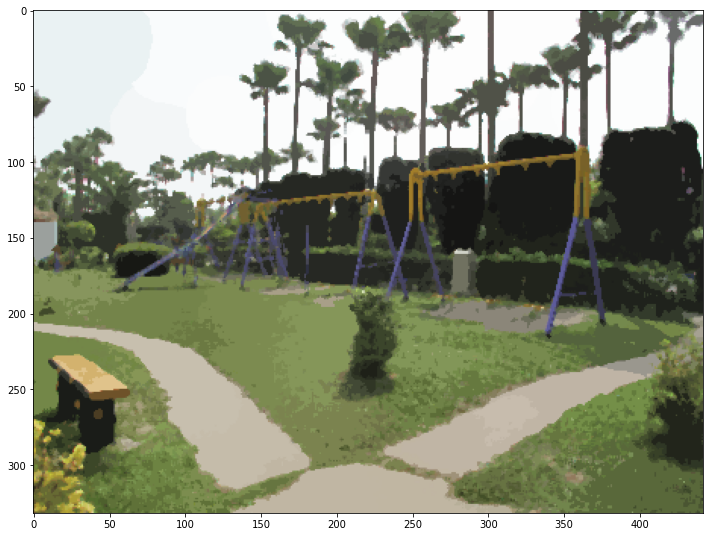

In [129]:
result = scaled_img.copy()
    
labels_2d = labels.reshape(result.shape[:2])
for label_idx in range(labels.max()+1):
    result[labels_2d == label_idx] = np.average(result[labels_2d == label_idx], axis=0)

result = cv.medianBlur(result, 3)

plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB));

## Original image

Unfortunately, we can't include $(X, Y)$ to our feature space in original image (It will cause the program to take so much longer time to finish). So, we just down scale the image, do the process and then resize it back to the original image. 

Since we're segmenting, down-scaling and then up-scaling here will not damage our result.

In [173]:
scaled_img = main_img[::7, ::7]

alpha = 0.2
features = np.dstack((
    cv.cvtColor(scaled_img, cv.COLOR_BGR2LUV),
    np.transpose(np.indices(scaled_img.shape[:2]), (1, 2, 0)) * alpha
))

_, labels = EnhancedMeanShift(radius=8, continue_with_neighbors_th=0.7).fit(
    features.reshape(-1, 5)
)

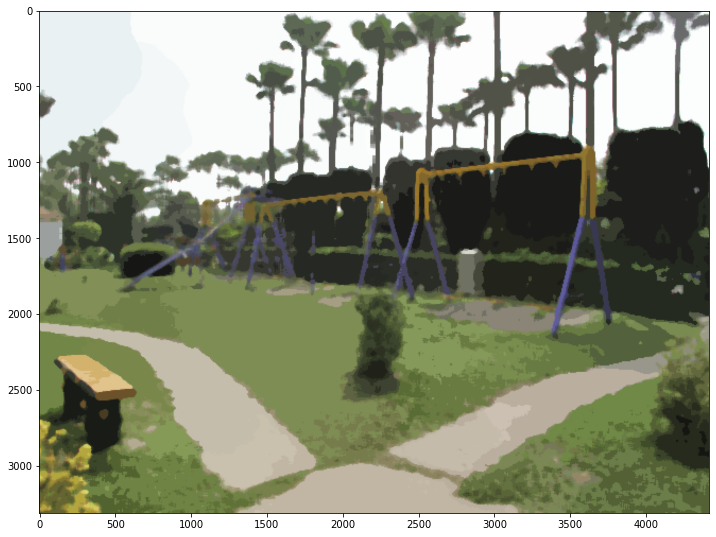

In [180]:
result = scaled_img.copy()
    
labels_2d = labels.reshape(result.shape[:2])
for label_idx in range(labels.max()+1):
    result[labels_2d == label_idx] = np.average(result[labels_2d == label_idx], axis=0)

result = cv.medianBlur(result, 5)

result = cv.resize(result, main_img.shape[:2][::-1], interpolation=cv.INTER_AREA)

plt.figure(figsize=(12, 12))
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB));

I have also ran some experiments on orignal image (without down scaling) without $(X, Y)$ features. But the above result was way better than them. So, I decided to stick with this result... 

Also, if you switch between the original image and the segmented one (above picture) quickly, you'll notice that it has segmented the image pretty accuratly... 